In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

CSV_PATH = "pp-2021.csv"

# Column indices
COL_VALUATION = 1
COL_DATE = 2
COL_POSTCODE = 3

# Date parsing
DATE_FORMAT = "%Y-%m-%d %H:%M"

# Time constants
MONTHS_PER_YEAR = 12

# Lags and rolling windows
LAG_1 = 1
LAG_LAST = 12 ## Sample is v. small.
MOVING_AVG_WINDOW = 12

# Train-test split
TEST_SIZE = 0.1
RANDOM_SEED = 42

TEST_POSTCODES = [
    "SW1A 1AA",
    "E14 5AB",
    "NW1 6XE",
]

In [ ]:
### Loading file ###
import glob

# =========================
# Constants
# =========================
CSV_PATTERN = "pp-*.csv"   # matches pp-2018.csv, pp-2019.csv, ..., pp-2025.csv

COL_VALUATION = 1
COL_DATE = 2
COL_POSTCODE = 3

DATE_FORMAT = "%Y-%m-%d %H:%M"

# =========================
# Load all CSVs
# =========================
file_list = sorted(glob.glob(CSV_PATTERN))  # sorted for consistency


# Prevent execution for now.
if True:
    dfs = []
    for file in file_list:
        df = pd.read_csv(file, header=None)

        # Keep only required columns
        df = df[[COL_VALUATION, COL_DATE, COL_POSTCODE]]
        df.columns = ["", "valuation", "date", "postcode"] + map(df.columns[4:].tolist(), "")
        
        # Ensure datetime
        df["date"] = pd.to_datetime(df["date"], format=DATE_FORMAT, errors="coerce")
        
        dfs.append(df)

# Concatenate all files into one massive DataFrame
df = pd.concat(dfs, ignore_index=True)

# Optional: sort by postcode and date
df = df.sort_values(["postcode", "date"]).reset_index(drop=True)

print(f"Loaded {len(dfs)} CSVs into one DataFrame with {len(df)} rows")


Loaded 31 CSVs into one DataFrame with 30906560 rows


In [19]:
# Remove most columns for testing
NUM_TEST_POSTCODES = 15
MIN_ENTRIES = 25

# Get postcodes sorted by frequency
postcode_counts = df["postcode"].value_counts()

# Keep only those with at least MIN_ENTRIES
eligible_postcodes = postcode_counts[postcode_counts >= MIN_ENTRIES]

# Take top NUM_TEST_POSTCODES
top_postcodes = eligible_postcodes.head(NUM_TEST_POSTCODES).index.tolist()

# Earliest date for reference
min_date = df["date"].min()

# Filter DataFrame
df = df[df["postcode"].isin(top_postcodes)].copy()
df["date"] = df["date"].dt.to_period("M")

# Sort for time series operations
df = df.sort_values(["postcode", "date"]).reset_index(drop=True)
df["time_plot"] = df["date"]

print(df["postcode"].unique())
print(df["date"].head())

<StringArray>
['BH13 6BH',  'BS3 3NG', 'CF10 3FH', 'CM21 9PF',  'CM7 1WG',  'E14 9GU',
   'L5 3AA',   'L7 3AA',  'LU1 5FT',   'M1 5GB',   'M5 3WH', 'RH10 3HZ',
  'TR8 4LX', 'WC2A 2AT', 'YO10 3FT']
Length: 15, dtype: str
0    1997-04
1    1997-04
2    1997-04
3    1997-04
4    1997-04
Name: date, dtype: period[M]


In [20]:
postcodes = df["postcode"].unique()
print(len(postcodes))

# Global monthly index
min_period = df["date"].min()

df["time_index"] = (
    (df["date"].dt.year - min_period.year) * MONTHS_PER_YEAR +
    (df["date"].dt.month - min_period.month)
)

df_by_period = df.groupby(
    ["postcode", "time_index", "time_plot"],
    as_index=False
).agg({"valuation": "mean"}).sort_values(["postcode", "time_index"]).reset_index(drop=True)


15


In [21]:
df_by_period["lag_1"] = df_by_period.groupby("postcode")["valuation"].shift(LAG_1)
df_by_period["lag_12"] = df_by_period.groupby("postcode")["valuation"].shift(LAG_LAST)
df_by_period["slow_ma"] = df_by_period.groupby("postcode")["valuation"].transform(
    lambda s: s.shift(1).rolling(MOVING_AVG_WINDOW).mean()
)

df_by_period = df_by_period.dropna()

In [22]:
print(df_by_period.groupby("postcode")["time_index"].min())
print(df_by_period.groupby("postcode")["time_index"].max())
print(df_by_period.groupby("postcode").size())

postcode
BH13 6BH     40
BS3 3NG     175
CF10 3FH    348
CM21 9PF     20
CM7 1WG      17
E14 9GU     337
L5 3AA      309
L7 3AA      275
LU1 5FT     285
M1 5GB      276
M5 3WH      292
RH10 3HZ    266
TR8 4LX      42
WC2A 2AT    303
YO10 3FT    275
Name: time_index, dtype: int64
postcode
BH13 6BH    369
BS3 3NG     368
CF10 3FH    368
CM21 9PF    366
CM7 1WG     369
E14 9GU     358
L5 3AA      368
L7 3AA      365
LU1 5FT     368
M1 5GB      364
M5 3WH      361
RH10 3HZ    291
TR8 4LX     370
WC2A 2AT    363
YO10 3FT    332
Name: time_index, dtype: int64
postcode
BH13 6BH    176
BS3 3NG      61
CF10 3FH      8
CM21 9PF    157
CM7 1WG     166
E14 9GU       4
L5 3AA       20
L7 3AA       29
LU1 5FT      33
M1 5GB       30
M5 3WH       39
RH10 3HZ     18
TR8 4LX     189
WC2A 2AT     31
YO10 3FT     33
dtype: int64


In [23]:
FEATURE_COLUMNS = ["time_index", "lag_1", "lag_12", "slow_ma"]

models = {}
metrics = {}

for postcode, g in df_by_period.groupby("postcode"):
    
    X = g[FEATURE_COLUMNS]
    y = g["valuation"]
    
    # Time-based split (NOT random)
    split_idx = int(len(g) * (1 - TEST_SIZE))
    
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    models[postcode] = model
    metrics[postcode] = {
        "r2": r2_score(y_test, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
        "n_obs": len(g)
    }

c:\Users\anant\Documents\MyProjects\RealtechHack\UCL-CSRI\hackathon_env\Lib\site-packages\sklearn\metrics\_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\anant\Documents\MyProjects\RealtechHack\UCL-CSRI\hackathon_env\Lib\site-packages\sklearn\metrics\_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [24]:
metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df.reset_index().rename(columns={"index": "postcode"})
metrics_df.describe()

,r2,rmse,n_obs
count,13.000000,1.500000e+01,15.000000
mean,-8.554373,1.428326e+05,66.266667
std,24.252446,3.550565e+05,67.590645
min,-88.727034,1.595438e+03,4.000000
25%,-2.747069,2.588498e+04,24.500000
50%,-0.642179,4.808399e+04,33.000000
75%,-0.161611,8.040665e+04,109.000000
max,-0.028320,1.419766e+06,189.000000


In [25]:
forecasts = {}

for postcode, g in df_by_period.groupby("postcode"):
    model = models[postcode]
    
    last_row = g.iloc[-1]
    X_next = last_row[FEATURE_COLUMNS].values.reshape(1, -1)
    
    forecasts[postcode] = model.predict(X_next)[0]

forecasts


c:\Users\anant\Documents\MyProjects\RealtechHack\UCL-CSRI\hackathon_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\anant\Documents\MyProjects\RealtechHack\UCL-CSRI\hackathon_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\anant\Documents\MyProjects\RealtechHack\UCL-CSRI\hackathon_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\anant\Documents\MyProjects\RealtechHack\UCL-CSRI\hackathon_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\anant\Documents\MyProje

{'BH13 6BH': np.float64(236971.1066983286),
 'BS3 3NG': np.float64(249062.61845097732),
 'CF10 3FH': np.float64(183994.63523310237),
 'CM21 9PF': np.float64(270593.31246926973),
 'CM7 1WG': np.float64(389334.7956511447),
 'E14 9GU': np.float64(684376.3067808195),
 'L5 3AA': np.float64(15375.50448032196),
 'L7 3AA': np.float64(27191.792163582984),
 'LU1 5FT': np.float64(35759.29374177137),
 'M1 5GB': np.float64(300060.6558685715),
 'M5 3WH': np.float64(187749.92048848188),
 'RH10 3HZ': np.float64(71506.80668728123),
 'TR8 4LX': np.float64(75976.92088564855),
 'WC2A 2AT': np.float64(3270513.616744927),
 'YO10 3FT': np.float64(93126.90207565084)}

In [29]:
# Forecast monthly until end of 2030 and plot historic + forecast
forecast_end = pd.Period("2030-12", freq="M")

all_forecasts = {}

for postcode, g in df_by_period.groupby("postcode"):
    model = models.get(postcode)
    if model is None:
        continue

    last_period = g["time_plot"].iloc[-1]            # Period (monthly)
    future_periods = pd.period_range(last_period + 1, forecast_end, freq="M")
    if len(future_periods) == 0:
        continue

    last_time_index = int(g["time_index"].iloc[-1])
    history_vals = list(g["valuation"].values)      # rolling history to update as we predict

    preds = []
    time_idxs = []
    slow_mas = []

    for step, p in enumerate(future_periods, start=1):
        ti = last_time_index + step
        lag_1 = history_vals[-1]
        lag_12 = history_vals[-12] if len(history_vals) >= 12 else history_vals[0]
        slow_ma = np.mean(history_vals[-MOVING_AVG_WINDOW:]) if len(history_vals) > 0 else np.nan

        X = np.array([ti, lag_1, lag_12, slow_ma]).reshape(1, -1)
        yhat = model.predict(X)[0]

        preds.append(yhat)
        time_idxs.append(ti)
        slow_mas.append(slow_ma)

        history_vals.append(yhat)   # feed prediction into history for next step

    forecast_df = pd.DataFrame({
        "postcode": postcode,
        "time_index": time_idxs,
        "time_plot": future_periods.astype(object),
        "valuation": preds,
        "slow_ma": slow_mas
    })
    all_forecasts[postcode] = forecast_df


c:\Users\anant\Documents\MyProjects\RealtechHack\UCL-CSRI\hackathon_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\anant\Documents\MyProjects\RealtechHack\UCL-CSRI\hackathon_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\anant\Documents\MyProjects\RealtechHack\UCL-CSRI\hackathon_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\anant\Documents\MyProjects\RealtechHack\UCL-CSRI\hackathon_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\anant\Documents\MyProje

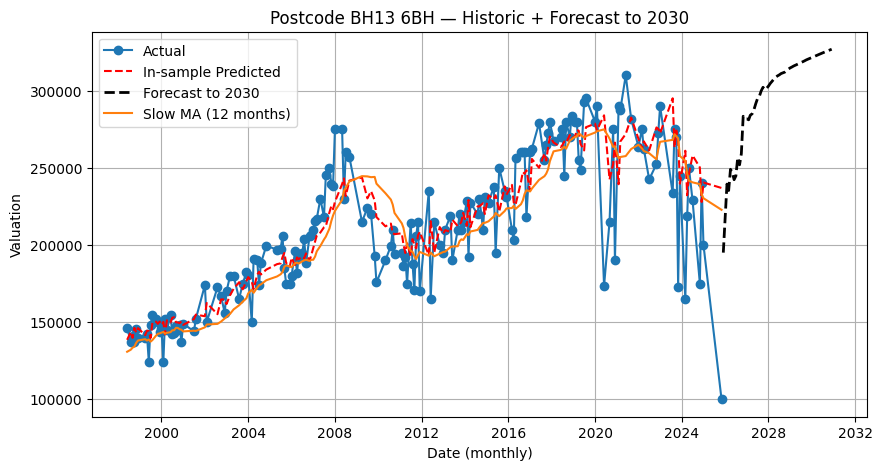

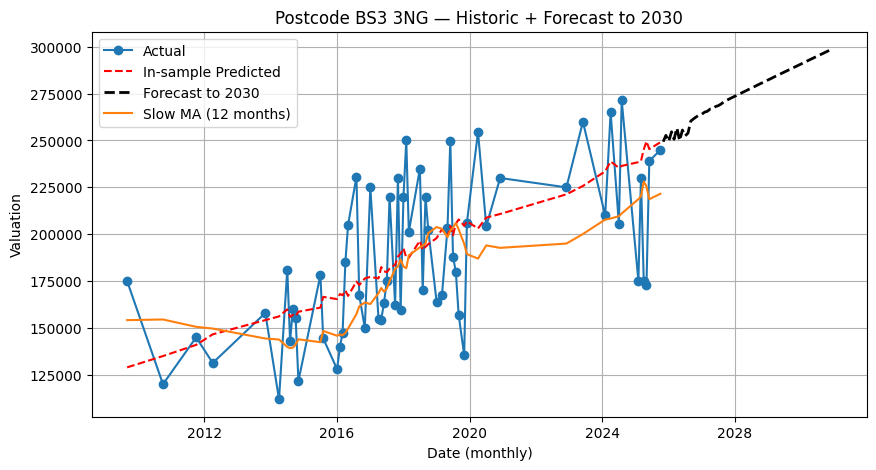

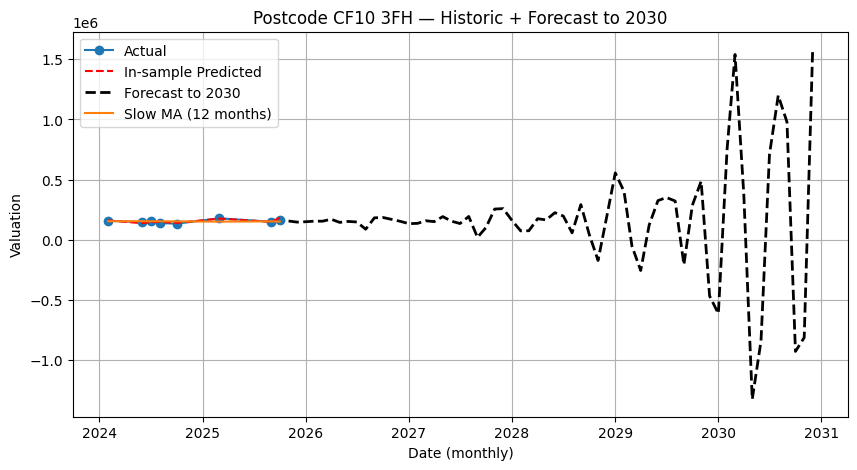

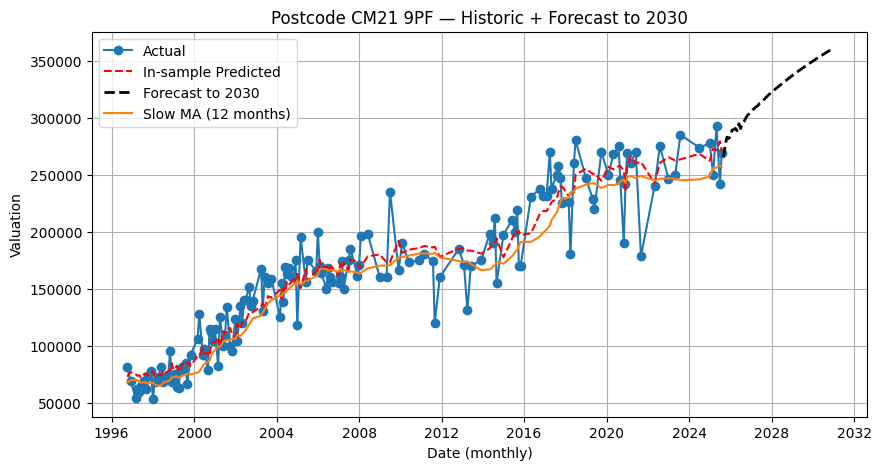

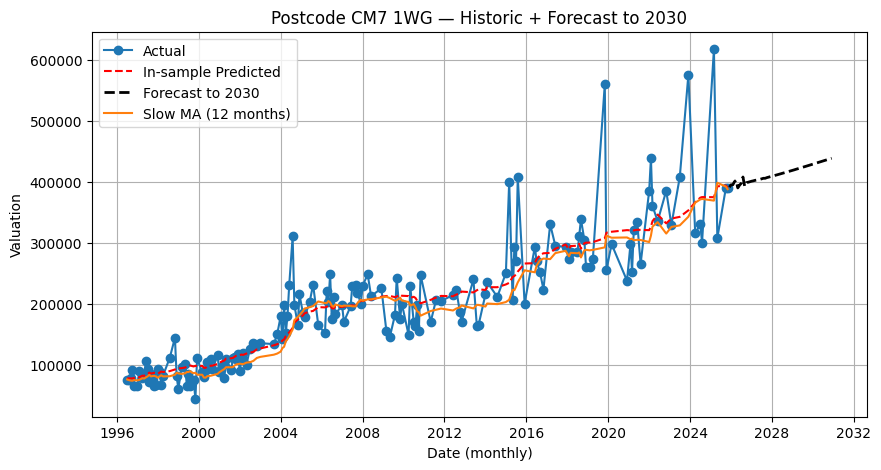

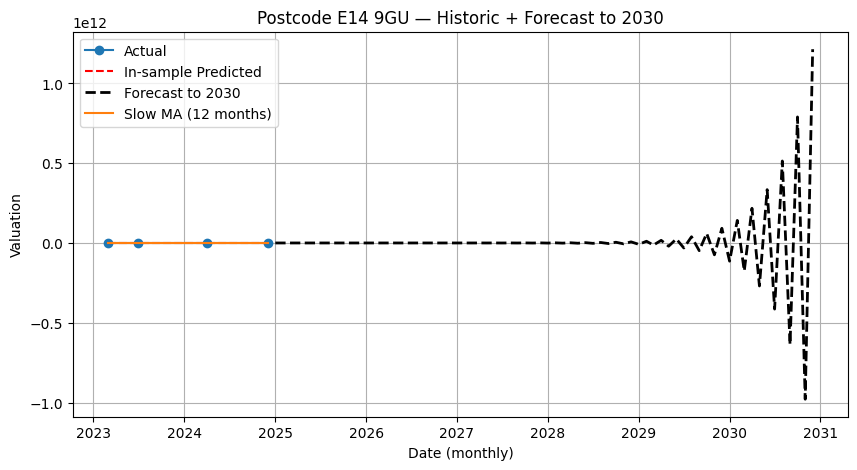

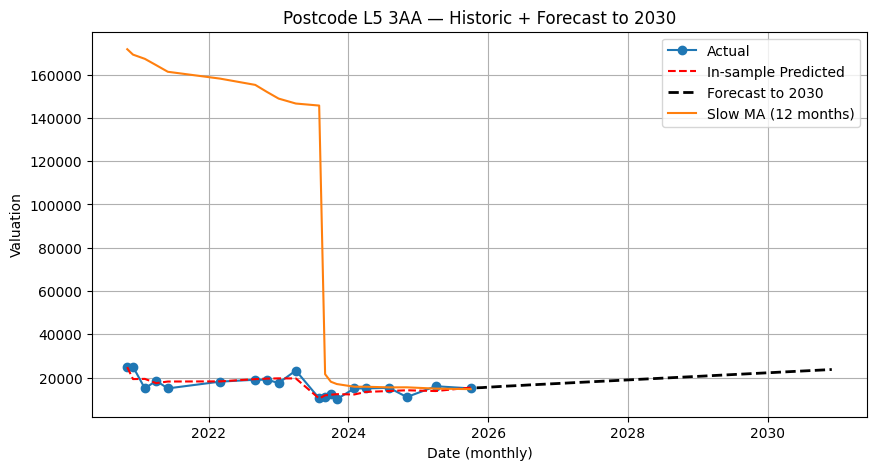

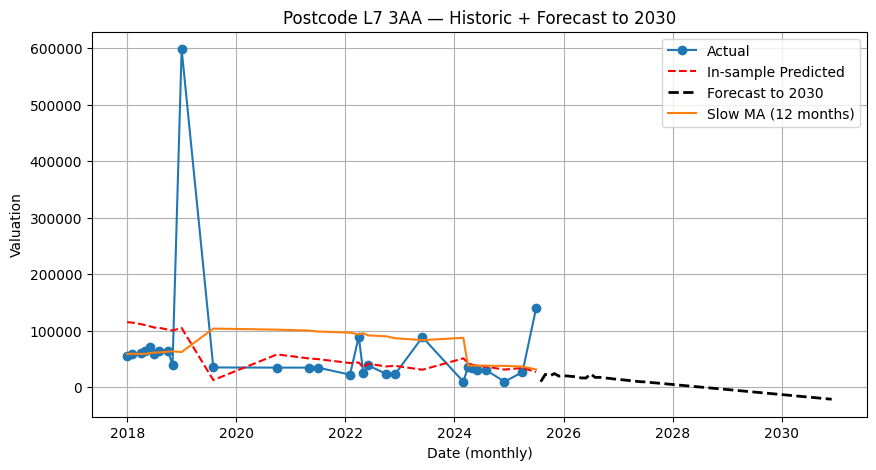

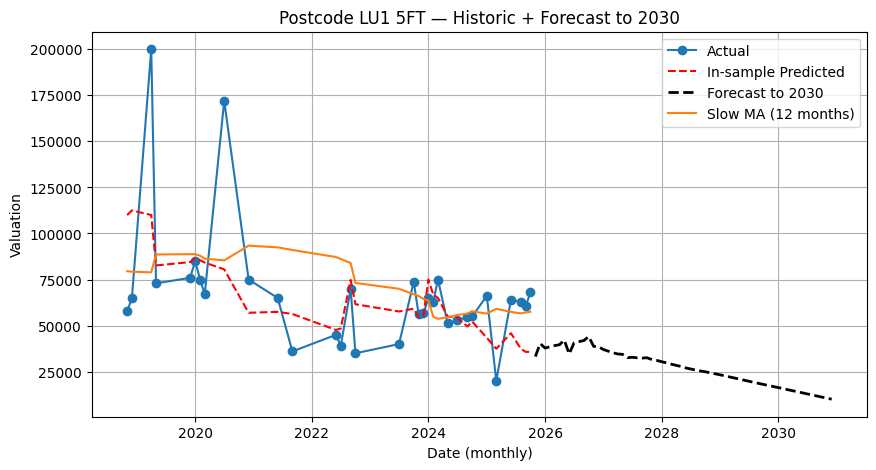

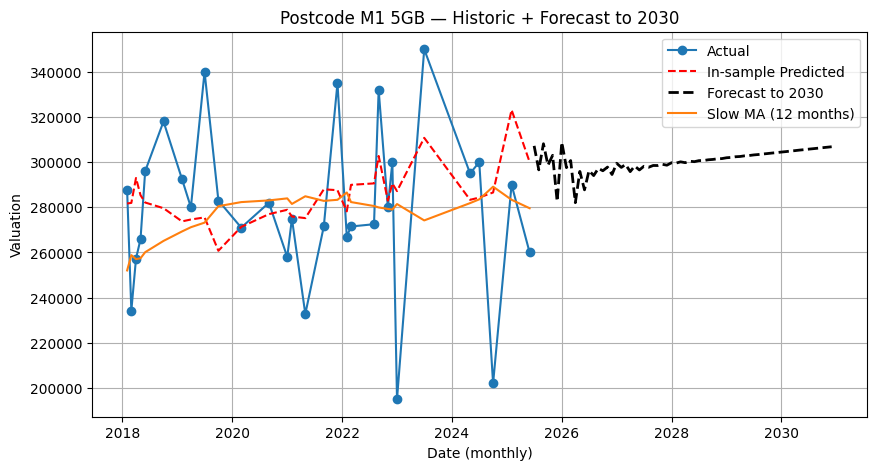

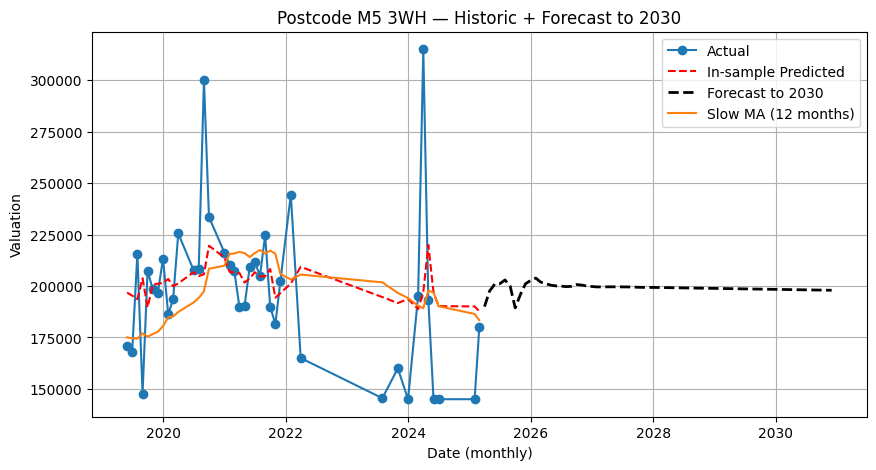

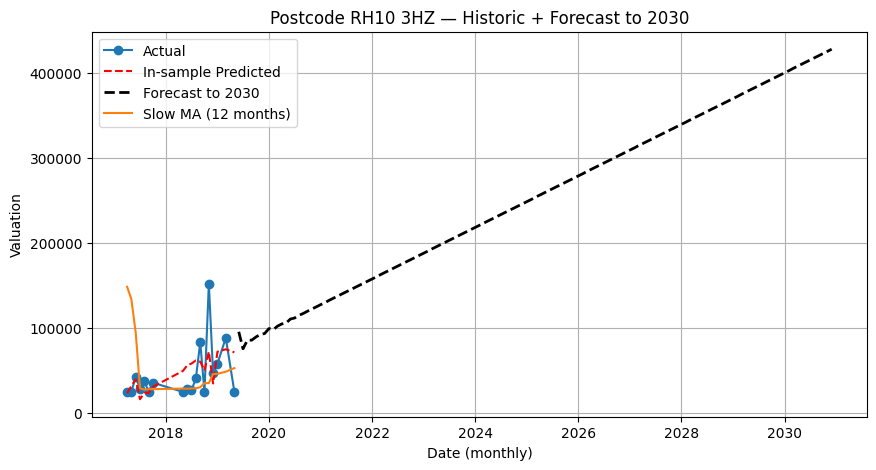

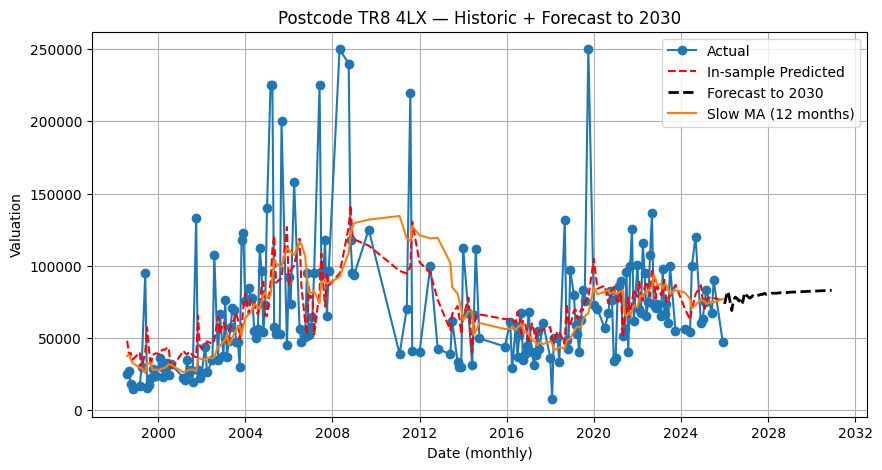

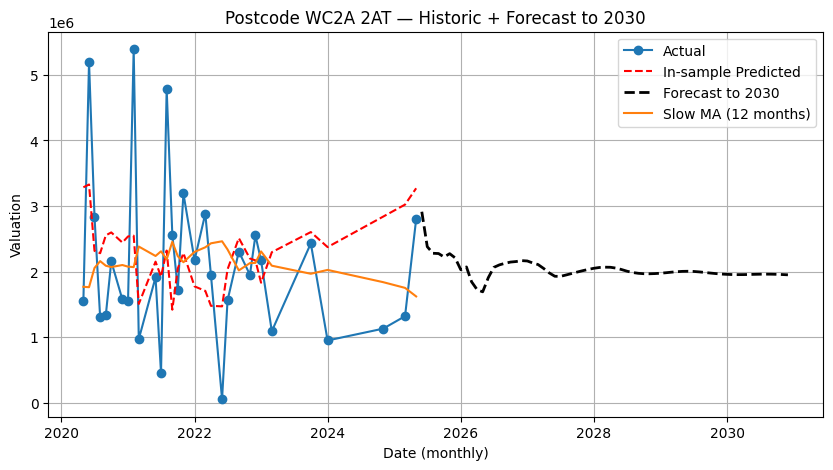

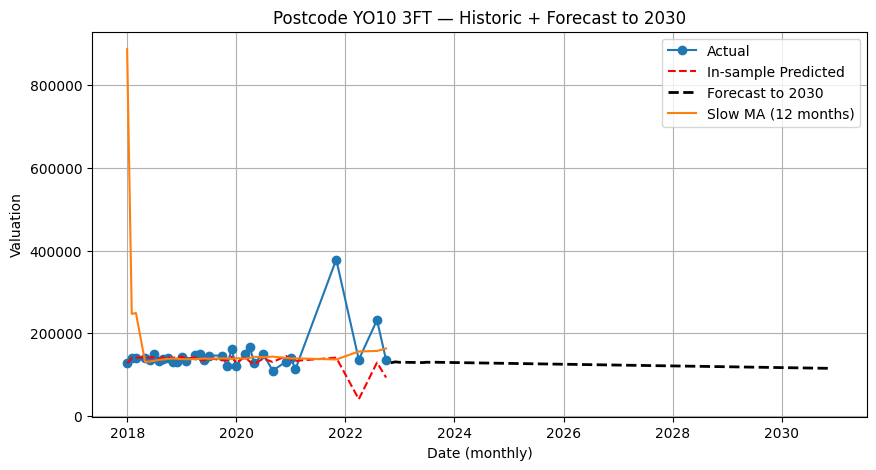

In [30]:
for postcode, g in df_by_period.groupby("postcode"):
    forecast_df = all_forecasts.get(postcode)
    if forecast_df is None:
        continue

    hist = g.copy()
    # convert Period -> Timestamp for plotting
    hist_dates = hist["time_plot"].dt.to_timestamp()
    fut_dates = pd.Series(forecast_df["time_plot"]).apply(lambda p: p.to_timestamp())

    plt.figure(figsize=(10, 5))
    plt.plot(hist_dates, hist["valuation"], "o-", label="Actual")
    plt.plot(hist_dates, models[postcode].predict(hist[FEATURE_COLUMNS]), "r--", label="In-sample Predicted")
    plt.plot(fut_dates, forecast_df["valuation"], "k--", linewidth=2, label="Forecast to 2030")
    plt.plot(hist_dates, hist["slow_ma"], label=f"Slow MA ({MOVING_AVG_WINDOW} months)")
    plt.title(f"Postcode {postcode} — Historic + Forecast to 2030")
    plt.xlabel("Date (monthly)")
    plt.ylabel("Valuation")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# area_forecasts = {}
# postcode_col = 3
# date_col = 2
# evaluation_col = 1

# for postcode in postcodes[:10]:
#     temp = df[df[postcode_col] == postcode].copy()
#     temp = temp.sort_values(by=date_col)
#     temp = temp[[date_col, evaluation_col]]

#     # Clean numeric column
#     temp[evaluation_col] = temp[evaluation_col].astype(str).str.replace(",", "").astype(float)

#     # Slow-moving mean (12-month window)
#     temp["slow_mean"] = temp[evaluation_col].rolling(window=12, min_periods=1).mean()

#     # Time index
#     temp["time_index"] = np.arange(len(temp))
    
#     area_forecasts[postcode] = temp


In [ ]:
# from sklearn.linear_model import LinearRegression
# linear_models = {}

# for area_name, temp in area_forecasts.items():
#     X = temp[["time_index"]]
#     y = temp["slow_mean"]
    
#     model = LinearRegression()
#     model.fit(X, y)
#     linear_models[area_name] = model
    
#     # Store long-term trend
#     temp["trend"] = model.predict(X)
#     area_forecasts[area_name] = temp


In [ ]:
# for area_name, temp in area_forecasts.items():
#     temp["residual"] = temp["slow_mean"] - temp["trend"]

In [ ]:
# forecast_horizon = 360
# ar_forecast_dict = {}  # store future residual forecasts

# for area_name, temp in area_forecasts.items():
#     residuals = temp["residual"].values
#     last_residual = residuals[-1]
    
#     ar_preds = []
#     for _ in range(forecast_horizon):
#         ar_pred = 0.8 * last_residual  # AR(1)
#         ar_preds.append(ar_pred)
#         last_residual = ar_pred
    
#     ar_forecast_dict[area_name] = ar_preds


In [ ]:
# final_forecast_dict = {}

# for area_name, temp in area_forecasts.items():
#     model = linear_models[area_name]
    
#     # future time index
#     future_index = np.arange(len(temp), len(temp)+forecast_horizon).reshape(-1,1)
    
#     # linear trend forecast
#     trend_forecast = model.predict(future_index)
    
#     # optional 2% annual growth
#     years = np.arange(forecast_horizon)/12
#     trend_forecast *= (1 + 0.02)**years
    
#     # combine with AR residuals
#     final_forecast = trend_forecast + ar_forecast_dict[area_name]
    
#     # store with future dates as index
#     future_dates = pd.date_range(temp[date_col].iloc[-1], periods=forecast_horizon, freq="ME")
#     final_forecast_dict[area_name] = pd.Series(final_forecast, index=future_dates)


In [ ]:
# for area_name, temp in area_forecasts.items():
#     future_forecast = final_forecast_dict[area_name]
    
#     plt.figure(figsize=(12,5))
#     plt.plot(temp[date_col], temp[evaluation_col], label="Historical Prices")
#     plt.plot(temp[date_col], temp["slow_mean"], label="Slow-Moving Mean", linewidth=2)
#     plt.plot(future_forecast.index, future_forecast.values, label="Hybrid Forecast", linewidth=2)
#     plt.title(f"30-Year Forecast: {area_name}")
#     plt.legend()
#     plt.show()


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_percentage_error

# mape_results = {}

# for area_name, temp in area_forecasts.items():
#     X = temp[["time_index"]]
#     y = temp["slow_mean"]
    
#     # 75% train, 25% test split
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
#     # Train model on training data
#     model = LinearRegression()
#     model.fit(X_train, y_train)
    
#     # Make predictions on test data
#     y_pred = model.predict(X_test)
    
#     # Calculate mean absolute percentage error
#     mape = mean_absolute_percentage_error(y_test, y_pred)
#     mape_results[area_name] = mape

# # Print results
# print("Mean Absolute Percentage Error (MAPE) for each area:")
# print("-" * 40)
# for area_name, mape in mape_results.items():
#     print(f"{area_name}: {mape:.2f}%")

# print("-" * 40)
# print(f"Average MAPE across all areas: {100.0 * np.mean(list(mape_results.values())):.2f}%")